# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 3A. Labelled Dataset - Modelling

## Introduction

In this notebook I perform basic modelling for the labelled dataset. This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Gridsearch for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. VADER sentiment analyser.
* 3.7. Textblob from NLTK
* 3.8. Conclusions

## 3.0 Data loading and data quality checks

In [21]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Sentiment Analysis Libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, recall_score, 
                             precision_score, confusion_matrix, f1_score, roc_curve, auc,
                             roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_val_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

In [2]:
DATAFILE = '../data/02_labelled_dataset_wo_emoji.csv'
df = pd.read_csv(DATAFILE)

## 3.1. Assigning target variable

In the code below I assign new binary labels to the target variable "Intent".  I experimented with various approaches, for example encoding only "yes" asnwers with 1s, and the rest of teh answers as 0s.  I run all of theclassification models on various combinations of encoding.  The best results are achieved when "yes" and "maybe" categories are encoded as 1s and "uncertain", "informative", and "no" are encoded as 0s.  

In [4]:
# Two options together
df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
# df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,link_id,parent_id,User,Text,Intent,Support,emoji_text
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,0,0,NaN
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",0,0,NaN
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",0,0,NaN
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent double down posted? 9 bill...,0,0,NaN
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,1,0,NaN


### 2.1.1. Custom Tokenization function

In [5]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [7]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

### Train test split

In [8]:

X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(3996,)

## 3.2. Vectorisation 

In [9]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3996, 1000)


In [11]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,absolutely,access,account,across,act,action,actual,actually,add,...,ya,yall,yeah,year,yes,yesterday,yet,yo,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### SMOTE sampling due to imbalance

In [12]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [55]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. SVM

In [19]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# from Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 300). O'Reilly Media. Kindle Edition. 

In [18]:
# Standard Scaling does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [20]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1000, 1000)

In [50]:
# Use StandardScaler with with_mean=False
svm_clf = make_pipeline(StandardScaler(with_mean=False),
                        LinearSVC(C=1, random_state=99, max_iter=100000))

# Fit the model
svm_clf.fit(X_matrix_train_dense, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc',
                 LinearSVC(C=1, max_iter=100000, random_state=99))])

In [51]:
cross_val_score(svm_clf, X_matrix_train, y_train).mean()

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres

0.7027043178973716

The accuracy score is 70%, not bad.

In [38]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [39]:
cross_val_score(poly_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7142162077596996

Even better! 71% accuracy

In [40]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="rbf", gamma=5, C=0.001))

rbf_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.001, gamma=5))])

In [41]:
cross_val_score(rbf_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7292293491864831

### 3.5.1. Set up a pipeline

In [42]:
# Define the hyperparameters
param_grid = [
    {'svc__kernel': ['rbf'],
     'svc__gamma': [0.1, 1, 5, 10],
     'svc__C': [0.001, 0.01, 0.1, 1, 10]},
    {'svc__kernel': ['linear'],
     'svc__C': [0.001, 0.01, 0.1, 1, 10]},
    {'svc__kernel': ['poly'],
     'svc__degree': [2, 3, 4],
     'svc__C': [0.001, 0.01, 0.1, 1, 10],
     'svc__coef0': [0, 1, 10]}
]

### 3.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [43]:
# Create the pipeline
final_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                   SVC())

# Create the GridSearchCV object
grid_search = GridSearchCV(final_svm_clf, param_grid, cv=5,
                           scoring='accuracy', verbose=2)

# Fit the GridSearchCV object
grid_search.fit(X_matrix_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=5, svc__kernel=rbf; total time=   0.6s
[CV] END ........svc__C=0.001, svc__gamma=5, sv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__gamma': [0.1, 1, 5, 10],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__coef0': [0, 1, 10], 'svc__degree': [2, 3, 4],
                          'svc__kernel': ['poly']}],
             scoring='accuracy', verbose=2)

In [44]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'svc__C': 0.01, 'svc__coef0': 10, 'svc__degree': 3, 'svc__kernel': 'poly'}


### 3.5.3. Parameters to optimize

In [45]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7550


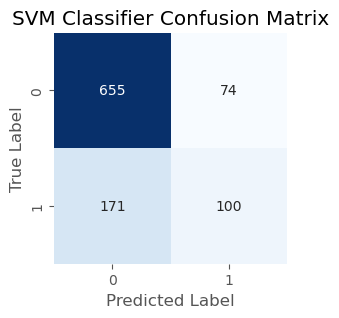

In [52]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix')
plt.show()

In [47]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       729
           1       0.57      0.37      0.45       271

    accuracy                           0.76      1000
   macro avg       0.68      0.63      0.65      1000
weighted avg       0.73      0.76      0.74      1000



Model evaluation

- The model performs well in identifying class 0, with high precision, recall, and F1-score.
- Performance for class 1 is significantly lower, with only about one-third of true class 1 instances being correctly identified.
- The overall accuracy of 76% is respectable, but it's important to note that this is heavily influenced by the model's stronger performance on class 0, which is more common in the dataset.
- The difference between macro and weighted averages suggests class imbalance, where the model is more tuned to the majority class (class 0).
- I should try to run this model with SMOTE or some other resampling method.